# Bayesian fits

This is a notebook showing a visualization of a Byesian interpretation for the line fit.
The idea is that we generate all possible line fits and reject them if they are not compatible with the data.
Naturally, this is not how most fits are done, but it illustrates the logic behind the Bayes Theorem when applied for fitting lines.


In [2]:
from typing import Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


We start by generating some fake dataset, which is simple enough that we can visualize the results easily. For this reason, the dataset will contain only two  variables.

The simulated example data will be $f(x) = 2 x + 1 + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu=0, \sigma=0.5)$.


In [8]:
true_alpha = 0.3
true_beta = 0.5
true_eps = 0.5
def generate_data(N: int) -> np.ndarray:
    x = 2*np.random.randn(N, 1)
    epsilon = true_eps*np.random.randn(N, 1)
    z = true_beta*x + true_alpha + epsilon
    return np.concatenate((x, z), axis=1).astype(np.float32)

data = generate_data(N=100)

Given some parameters $\alpha$ and $\beta$, we don't know the true $f(x)$, but we assume it is something like $f(x) = \beta x + \alpha$.

In [9]:
def f(x: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    return beta*x + alpha

Let's plot it for reference:

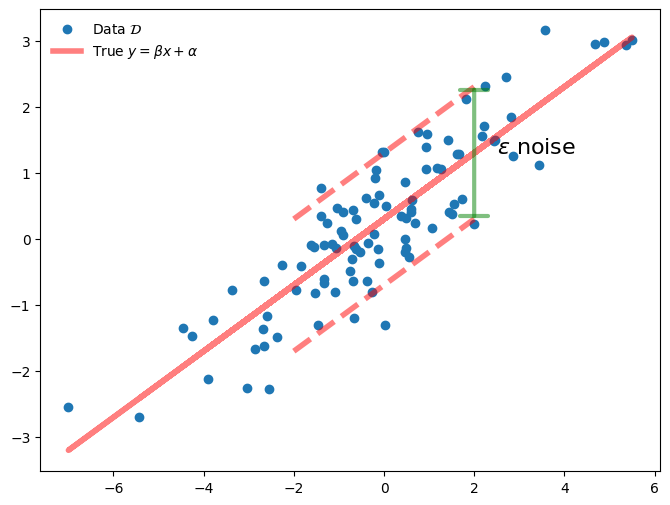

In [48]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(data[:,0], data[:,1], label=r"Data $\mathcal{D}$")
plt.plot(data[:,0], f(data[:,0], true_alpha, true_beta), c='r', ls='-', alpha=0.5, lw=4, label=r"True $y=\beta x + \alpha$")
xs = np.linspace(-2, 2, 10)
plt.plot(xs, f(xs, true_alpha, true_beta) - 2*true_eps, c='r', ls='--', alpha=0.5, lw=4)
plt.plot(xs, f(xs, true_alpha, true_beta) + 2*true_eps, c='r', ls='--', alpha=0.5, lw=4)
xa = 2
ya = f(xa, true_alpha, true_beta)
plt.annotate(xy=(xa, ya + 2*true_eps), xytext=(xa, ya - 2*true_eps), arrowprops=dict(arrowstyle='|-|', lw=3, alpha=0.5, color="green"), text=r"")
plt.text(xa+0.5, ya, s=r"$\epsilon$ noise", size=16)
plt.legend(frameon=False)
plt.savefig("data.png")

Let's show several random lines and reject the ones that do not agree with the likelihood:

In [49]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [59]:
def get_log_prior(A, B):
    #return 0.25*A/A/1/5
    return -0.5*A**2/1**2 - 0.5*B**2/1**2 #- (2*np.pi*p_width**2)
def sample_prior() -> Tuple[float, float]:
    #return (2*np.random.rand() - 1)*1, (2*np.random.rand() - 1)*5
    return 1*np.random.randn(), 1*np.random.randn()
def get_log_likelihood(x, y, A, B, sigma):
    error = f(x, A, B) - y
    return np.sum(-0.5*error**2/sigma**2, axis=0) # - (2*np.pi*sigma**2)
def plot(I: int):
    # how many lines to show in last column
    K = 20
    # assumed noise std. dev.
    sigma=0.5
    # region of alpha and beta to plot
    R = 4
    # take a subset of data points
    D = data[:I,:]
    # make plot
    fig, ax = plt.subplots(figsize=(4*5, 4), ncols=4)
    # create alpha and beta grid
    A = np.linspace(-R, R, 50)
    B = np.linspace(-R, R, 50)
    A, B = np.meshgrid(A, B)
    
    # calculate the log prior
    log_prior = get_log_prior(A, B)
    # calculate the log likelihood
    log_likelihood = get_log_likelihood(D[:, 0, np.newaxis, np.newaxis],
                                        D[:, 1, np.newaxis, np.newaxis],
                                        A[np.newaxis, ...],
                                        B[np.newaxis, ...],
                                        sigma=sigma)
    # the log posterior is, except for a constant factor, just the sum of those
    log_posterior = log_prior + log_likelihood

    m=ax[0].imshow(np.exp(log_prior), extent=(-R, R, -R, R), aspect="equal")
    #plt.colorbar(m,ax=ax[0], orientation="horizontal")
    ax[0].set(xlabel=r"$\alpha$", ylabel=r"$\beta$", title=r"$p(\alpha, \beta)$")
    
    m=ax[1].imshow(np.exp(log_likelihood), extent=(-R, R, -R, R), aspect="equal")
    #plt.colorbar(m,ax=ax[1], orientation="horizontal")
    
    ax[1].set(xlabel=r"$\alpha$", ylabel=r"$\beta$", title=r"$p(\mathcal{D}|\alpha,\beta)$")
    m=ax[2].imshow(np.exp(log_posterior), extent=(-R, R, -R, R), aspect="equal")
    #plt.colorbar(m,ax=ax[2], orientation="horizontal")
    ax[2].set(xlabel=r"$\alpha$", ylabel=r"$\beta$", title=r"$p(\alpha, \beta|\mathcal{D})$")

    if I > 0:
        ax[3].scatter(D[:, 0], D[:,1], label="Data")
    ax[3].set(xlabel="x", ylabel="y", title="Data", xlim=(-5, 5), ylim=(-5, 5))

    # sample alpha and beta
    def get_line():
        a, b = sample_prior()
        if len(D) == 0:
            return a, b
        for _ in range(1000):
            ap, bp = a + 0.1*np.random.randn(), b + 0.1*np.random.randn()
            A = min(1, np.exp(get_log_likelihood(D[:, 0], D[:, 1], ap, bp, sigma=sigma) - get_log_likelihood(D[:, 0], D[:, 1], a, b, sigma=sigma) ))
            if np.random.rand() <= A:
                a = ap
                b = bp
        return a, b
    for _ in range(K):
        a, b = get_line()
        ax[3].axline((0, a), slope=b, lw=2, ls='-', c='r', alpha=0.5)
    #plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(f"bayes_reg_{I}.png")

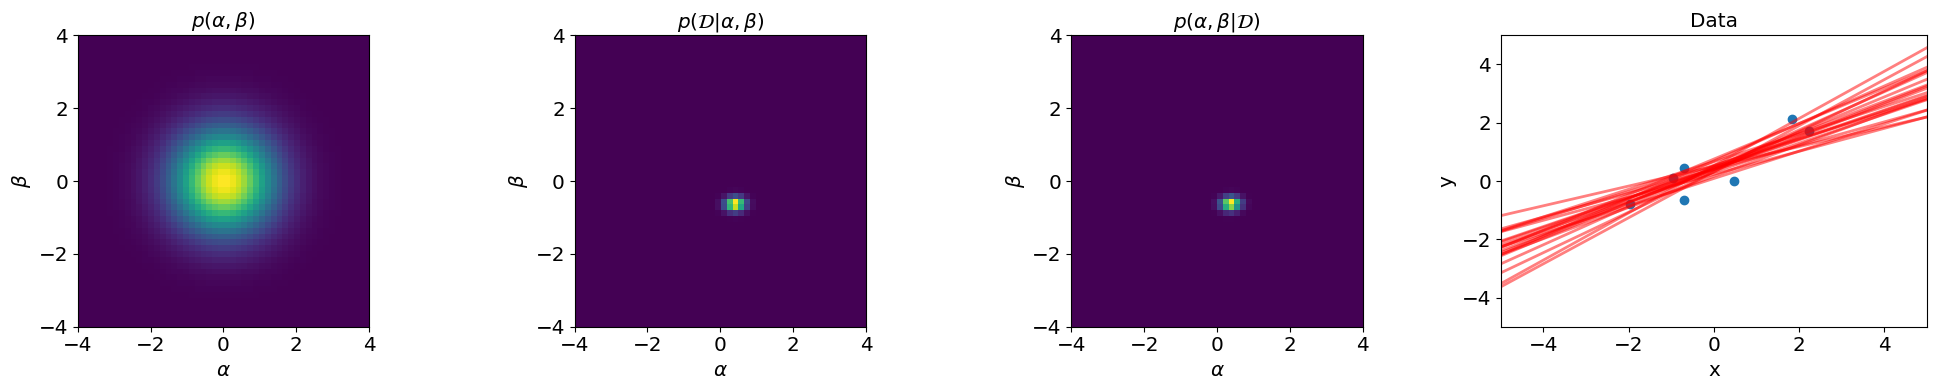

In [67]:
plot(I=7)